# SPAM MESSAGE DETECTION
# Natural Language Processing with Multinomial Naive Bayes Classifier 

<b>Steps:</b>
1. Imports
2. Get the Data adn Create the Dataframe
3. Explore the Data
4. Text Pre-processing
   - Remove Punctuations and list the words
   - Join back the words
   - Remove Stopwords
5. Vectorization of the words
6. Weighting and normalization
7. Training a model on full data
8. Model Evaluation
9. Train Test Split
10. Creating a Data Pipeline
11. Testing a sample

## 1 - Imports

In [54]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2 - Get the Data and Create the Dataframe

 - The data we have is not csv, in order to open with Pandas we need to check how the elements are seperated in the file

In [55]:
messages = [row.rstrip() for row in open('SMSSpamCollection')]
print(len(messages))

5574


In [56]:
# Displaying the first messages to see how its constructed
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

- With '\t' its clear that this is a tab seperated file.
- There are two elements in it --> <b>Label</b> and the <b>message</b>.
- Now we can open this with Pandas by mentioning the seperator as '\t' and names as 'label' and 'message'.

In [57]:
df_messages = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])

In [58]:
df_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 3 - Explore the Data

In [59]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [60]:
df_messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [61]:
df_messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

 - Inorder to analyze further, let's create a column for the the length of the messages

In [62]:
# Create the length column
df_messages['length'] = df_messages['message'].apply(len)

In [63]:
df_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<AxesSubplot:ylabel='Frequency'>

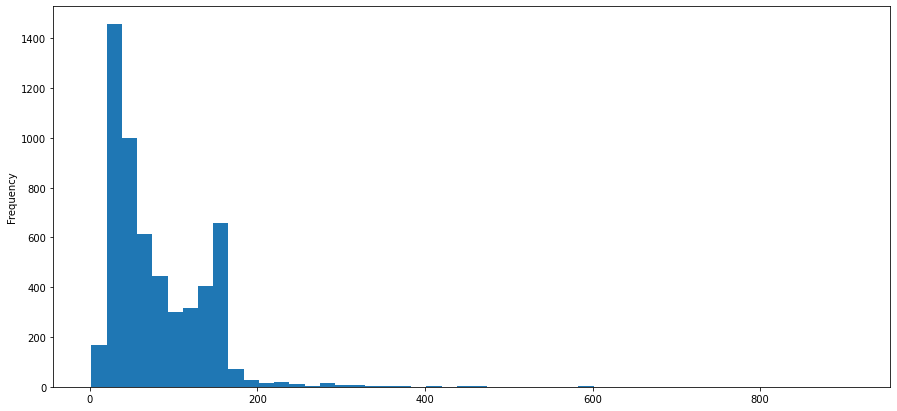

In [64]:
plt.figure(figsize=(15,7))
df_messages['length'].plot(kind='hist',bins=50) 

- Length of the messages ranges between 10 to 200.
- It seems there are messages even lengthier than 400. 
- Let's check them

In [65]:
df_messages[df_messages['length'] > 400]['message']

1085    For me the love should start with attraction.i...
1513    Hey sweet, I was wondering when you had a mome...
1579    How to Make a girl Happy? It's not at all diff...
1863    The last thing i ever wanted to do was hurt yo...
2010    I can't keep going through this. It was never ...
2158    Sad story of a Man - Last week was my b'day. M...
2370    A Boy loved a gal. He propsd bt she didnt mind...
2380    Good evening Sir, hope you are having a nice d...
2408    Solve d Case : A Man Was Found Murdered On  &l...
2434    Indians r poor but India is not a poor country...
2681    Solve d Case : A Man Was Found Murdered On  &l...
2849    Sad story of a Man - Last week was my b'day. M...
3017    &lt;#&gt;  is fast approaching. So, Wish u a v...
3280    Solve d Case : A Man Was Found Murdered On  &l...
4399    Can you tell Shola to please go to college of ...
4905    no, i *didn't* mean to post it. I wrote it, an...
5104    A Boy loved a gal. He propsd bt she didnt mind...
Name: message,

In [66]:
len(df_messages[df_messages['length'] > 400]['message'])

17

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

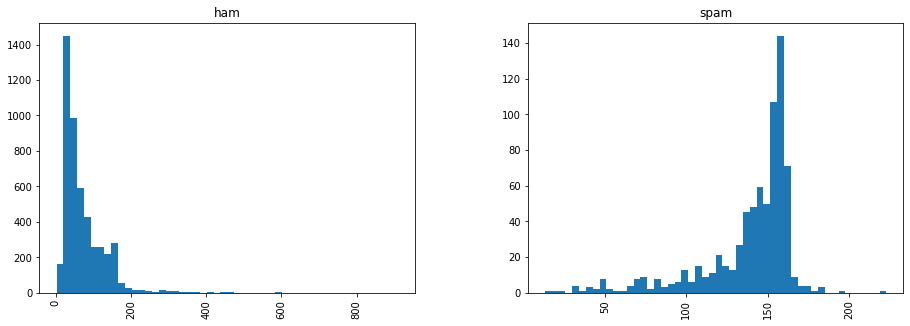

In [67]:
df_messages.hist(column='length', by='label', bins=50, figsize=(15,5))

- Most of the Normal messages tend to have around 50 characters while the most of the spam messages contains aroud 160 characters.

## 4 - Text Pre-processing

- We will use the bag-of-words approach, where each unique word in a text will be represented by one number.
- we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).
- Initially, we'll put each letter of the message in a list that are not punctuations.
- then join again and create words that contains no punctuations.
- Then we'll remove the stopwords.
- let's create a fundtion to do this work.

### Testing a sample for removing punctuations

In [68]:
df_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [69]:
import string

mess_test = df_messages['message'][10]
print('MESSAGE BEFORE REMOVING THE PUNCTUATIONS: ')
print(mess_test)
print('-----------------------------------------------------')
# place each letter that are not punctuations in a list
nopunc_letters = [char for char in mess_test if char not in string.punctuation]
# Join the characters again to form the string.
# nopunc_letters
nopunc_mess = ''.join(nopunc_letters)
print('MESSAGE AFTER REMOVING THE PUNCTUATIONS: ')
print(nopunc_mess)

MESSAGE BEFORE REMOVING THE PUNCTUATIONS: 
I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
-----------------------------------------------------
MESSAGE AFTER REMOVING THE PUNCTUATIONS: 
Im gonna be home soon and i dont want to talk about this stuff anymore tonight k Ive cried enough today


### Testing - Removal of stopword

In [70]:
from nltk.corpus import stopwords

In [71]:
# shows some stopwords
stopwords.words('english')[0:10] 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [72]:
# Split the message without punctuations that we created earlier
nopunc_mess.split()[0:8]

['Im', 'gonna', 'be', 'home', 'soon', 'and', 'i', 'dont']

In [73]:
# Now let's remove any stopwords
clean_words = [word for word in nopunc_mess.split() if word.lower() not in stopwords.words('english')]

In [74]:
clean_words[0:8]

['Im', 'gonna', 'home', 'soon', 'dont', 'want', 'talk', 'stuff']

### Let's create a function to apply to the Dataframe

In [75]:
def text_handler(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuations and put the letters in a list
    2. join the letters and create the words without puntuations
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Remove all punctuations and put the letters in a list
    nopunc_letters = [char for char in message if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc_mess = ''.join(nopunc_letters)
    
    # Remove any stopwords
    return [word for word in nopunc_mess.split() if word.lower() not in stopwords.words('english')]

In [76]:
# Check to make sure its working
# This is not applying to the dataframe --> only checking
df_messages['message'].head().apply(text_handler)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [77]:
df_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## 5 - Vectorization of the words

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

In [79]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_handler)
bow_transformer.fit(df_messages['message'])

CountVectorizer(analyzer=<function text_handler at 0x00000144090C2790>)

In [80]:
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


### Test the vectorization

In [81]:
# Access a sample message 
message_14 = df_messages['message'][14]
print(message_14)
# Transform the sample message to bow
bow_14 = bow_transformer.transform([message_14])
print(bow_14)
print(bow_14.shape)

I HAVE A DATE ON SUNDAY WITH WILL!!
  (0, 1568)	1
  (0, 3567)	1
(1, 11425)


- So there are two unique words in this message which is after removing the stop words.
- Each appear once.
- Let's check which words it has got.

In [82]:
print(bow_transformer.get_feature_names()[1568])
print(bow_transformer.get_feature_names()[3567])

DATE
SUNDAY


In [83]:
messages_bow = bow_transformer.transform(df_messages['message'])

In [84]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [85]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


In [86]:
messages_bow.shape

(5572, 11425)

## 6 - Weighting and normalization with TF-IDF

**Example:**

 - Consider a sentence containing 100 words wherein the word 'cat' appears 3 times. 
 - The **term frequency** (i.e., tf) for cat is then (3 / 100) = 0.03. 
 - Now, assume we have 10,000,000 rows of data and the word cat appears in 1,000 of these. Then, the **inverse document frequency** (i.e., idf) is calculated as **log(10,000,000 / 1,000)** = 4. 
 - Thus, the **Tf-idf weight** is the product of these quantities: 0.03 * 4 = 0.12.

In [87]:
from sklearn.feature_extraction.text import TfidfTransformer

In [88]:
tfidf_transformer = TfidfTransformer()

In [89]:
tfidf_transformer.fit(messages_bow)

TfidfTransformer()

### Testing TF-IDF with a single Message

In [90]:
tfidf_14 = tfidf_transformer.transform(bow_14)

In [91]:
print(tfidf_14)

  (0, 3567)	0.7285935995208821
  (0, 1568)	0.6849462509841224


- We'll go ahead and check what is the IDF (inverse document frequency) of the word `"c"` and of word `"company"`?

In [92]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['c']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['company']])

5.775541185859478
6.853100065329755


In [93]:
#Transform the entire bag-of-words corpus into TF-IDF corpus at once:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [94]:
print(messages_tfidf.shape)

(5572, 11425)


## 7 - Training a model on full data

In [95]:
from sklearn.naive_bayes import MultinomialNB

In [96]:
spam_detection_model = MultinomialNB().fit(messages_tfidf, df_messages['label'])

In [97]:
# Testing the prediction with the actual
print('Prediction: ', spam_detection_model.predict(tfidf_14)[0])
print('Actual:', df_messages['label'][14])

Prediction:  ham
Actual: ham


## 8 - Model Evaluation

In [98]:
all_predictions = spam_detection_model.predict(messages_tfidf)

In [99]:
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [100]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(df_messages['label'], all_predictions))
print(confusion_matrix(df_messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572

[[4825    0]
 [ 115  632]]


- In the above "evaluation",we evaluated accuracy on the same data we used for training. 
- We should never actually evaluate on the same dataset you train on because such evaluation tells us nothing about the true predictive power of our model.
- A proper way is to split the data into a training/test set, where the model only ever sees the training data during its model fitting and parameter tuning. The test data is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.
- After the previous steps, creating and training the model for training data will be easier with Pipeline..

## 9 -Train Test Split

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X = df_messages['message']
y = df_messages['label']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [104]:
print(len(X_train), len(X_test), len(y_train) + len(y_test))

4457 1115 5572


## 10 - Creating a Data Pipeline

In [105]:
from sklearn.pipeline import Pipeline

In [106]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_handler)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [107]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_handler at 0x00000144090C2790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [108]:
predictions = pipeline.predict(X_test)

In [109]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1012
        spam       0.71      1.00      0.83       103

    accuracy                           0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115



In [110]:
print(confusion_matrix(predictions,y_test))

[[969  43]
 [  0 103]]


## 11 - Testing a sample

In [111]:
data = input('PLEASE INPUT THE TEXT: ')
test_to_predict = pd.Series(np.array([data]))
test_to_predict
predict_new = pipeline.predict(test_to_predict)
predict_new

PLEASE INPUT THE TEXT: CONGRATULATIONS! We chose your number to get a chance to win QR100.000! Reply with "YES" now for FREE and participate NOW! JUST QR5/day


array(['spam'], dtype='<U4')